In [1]:
import pandas as pd
from pyspark.sql import SparkSession
import psutil
import time
import timeit
import seaborn as sns
import matplotlib.pyplot as plt

spark = SparkSession.builder \
    .appName("Resource Utilization") \
    .getOrCreate()

file_paths = [
    'splitted/emails_part_1.csv',
    'splitted/emails_part_2.csv',
    'splitted/emails_part_3.csv',
    'splitted/emails_part_4.csv',
    'splitted/emails_part_5.csv',
    'splitted/emails_part_6.csv'
]


23/05/07 18:25:04 WARN Utils: Your hostname, Merons-MacBook-Air.local resolves to a loopback address: 127.0.0.1, but we couldn't find any external IP address!
23/05/07 18:25:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/07 18:25:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
def measure_resource_utilization(operation, dataframe):
    cpu_percent_initial = psutil.cpu_percent() 77
    memory_initial = psutil.virtual_memory().used

    operation(dataframe)  
    

    cpu_percent_final = psutil.cpu_percent() 47
    memory_final = psutil.virtual_memory().used

    cpu_percent_diff = cpu_percent_final - cpu_percent_initial
    memory_diff = memory_final - memory_initial

    return cpu_percent_diff, memory_diff

agg_function = {"Date": "count"}
groupby_column = "From"

def operation_pandas(dataframe):
    dataframe.groupby(groupby_column).agg(agg_function)

def operation_spark(dataframe):
    dataframe.groupby(groupby_column).agg(agg_function)

def average_time(timings):
    return sum(timings) / len(timings)

def resource_utilization_average(file_paths, operation, read_func, cycles=10):
    cpu_diffs = []
    memory_diffs = []

    for file_path in file_paths:
        cpu_diff_cycle = []
        memory_diff_cycle = []

        for _ in range(cycles):
            df = read_func(file_path)
            cpu_diff, memory_diff = measure_resource_utilization(operation, df)
            cpu_diff_cycle.append(cpu_diff)
            memory_diff_cycle.append(memory_diff)

        cpu_diffs.append(average_time(cpu_diff_cycle))
        memory_diffs.append(average_time(memory_diff_cycle))

    return cpu_diffs, memory_diffs

def read_csv_pandas(file_path):
    return pd.read_csv(file_path)

def read_csv_spark(file_path):
    return spark.read.csv(file_path, header=True, inferSchema=True)


In [20]:
dd = file_paths[5]

print (measure_resource_utilization(operation_pandas, read_csv_spark(dd)))
print (measure_resource_utilization(operation_spark, read_csv_spark(dd)))





(-8.3, 208896)


(-65.2, 4096)


In [22]:
# Pandas
cpu_diffs_pandas, memory_diffs_pandas = resource_utilization_average(file_paths, operation_pandas, read_csv_pandas)

# Spark
cpu_diffs_spark, memory_diffs_spark = resource_utilization_average(file_paths, operation_spark, read_csv_spark)

print (cpu_diffs_pandas, memory_diffs_pandas)
print (cpu_diffs_spark, memory_diffs_spark)

[-5.85, -2.88, -0.3400000000000002, 1.0300000000000002, -1.8399999999999999, 2.04] [3686.4, 20480.0, 64716.8, 90112.0, 535347.2, 4253696.0]
[-9.489999999999998, -12.79, -20.310000000000002, -30.610000000000003, -17.589999999999996, -32.88] [215859.2, 9011.2, 0.0, 22528.0, 118784.0, 12288.0]


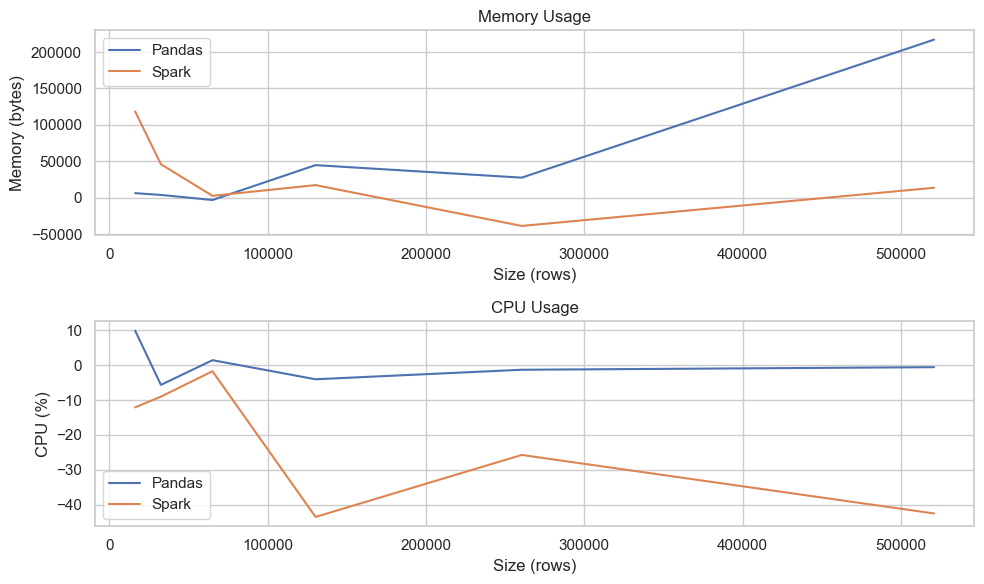

In [5]:

# Pandas
cpu_diffs_pandas, memory_diffs_pandas = resource_utilization_average(file_paths, operation_pandas, read_csv_pandas)

# Spark
cpu_diffs_spark, memory_diffs_spark = resource_utilization_average(file_paths, operation_spark, read_csv_spark)

# Plot results - Thes file sizes, are the rows with in the dataset
file_sizes = [16278, 32556, 65112, 130225, 260450, 520901]

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Memory
plt.subplot(2, 1, 1)
plt.plot(file_sizes, memory_diffs_pandas, label="Pandas")
plt.plot(file_sizes, memory_diffs_spark, label="Spark")
plt.xlabel("Size (rows)")
plt.ylabel("Memory (bytes)")
plt.legend()
plt.title("Memory Usage")

# CPU
plt.subplot(2, 1, 2)
plt.plot(file_sizes, cpu_diffs_pandas, label="Pandas")
plt.plot(file_sizes, cpu_diffs_spark, label="Spark")
plt.xlabel("Size (rows)")
plt.ylabel("CPU (%)")
plt.legend()
plt.title("CPU Usage")

plt.tight_layout()
plt.show()
